<a href="https://colab.research.google.com/github/aSafarpoor/Seminar/blob/main/Full_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

based on:
https://towardsdatascience.com/neural-network-collaborative-filtering-with-amazon-book-reviews-c50a919a84a7

and 

https://github.com/kenhua15/Projects/tree/master/5%20-%20amazon_recommendation_system


---


and related paper title: **"Justifying Recommendations using Distantly-Labeled Reviews and
Fine-Grained Aspects"**

address:
https://cseweb.ucsd.edu//~jmcauley/pdfs/emnlp19a.pdf

---

data source:
https://nijianmo.github.io/amazon/index.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/MSc/codes/"Neural Network Collaborative Filtering with Amazon Book Reviews"
!ls

/content/drive/MyDrive/MSc/codes/Neural Network Collaborative Filtering with Amazon Book Reviews
Data_Prep_Functions.py		 Modeling_Functions.py	__pycache__
Full_Project.ipynb		 NLP_Functions.py
Grocery_and_Gourmet_Food_5.json  NN_Model.py


In [3]:
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Grocery_and_Gourmet_Food_5.json.gz

In [4]:
# !gunzip -k Grocery_and_Gourmet_Food_5.json.gz
## ! rm Grocery_and_Gourmet_Food_5.json.gz

In [5]:
# !ls

### Data Loading and Preprocessing

Data is loaded from the Amazon Review Dataset. First step is to import packages.

In [ ]:
!pip install --user flair

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import Data_Prep_Functions as DP
import Modeling_Functions as MF
import NLP_Functions as NL
import tensorflow as tf

from flair.models import TextClassifier
from flair.data import Sentence
import re

from scipy.sparse.linalg import svds

from tqdm import tqdm

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)



Data is loaded in chunks, filtered by comment length, then apppended to a list. To save time, we will just load in the file that we processed earlier.

In [8]:
review_json_path = 'Grocery_and_Gourmet_Food_5.json'

size = 1000000
review = pd.read_json(review_json_path, lines=True,
                      chunksize=size)

total_list = []

def filter_comment_lengths(reviews, minimum, maximum):
    #Filters reviews based on word length, between a minimum and maximum
    #Returns the df with word length as an additional column, and filtered rows of comments between min and max
    reviews['reviewText'] = reviews['reviewText'].astype('str')
    reviews['reviewLen'] = reviews['reviewText'].str.split().map(lambda x: len(x))
    reviews = reviews.loc[(reviews['reviewLen'] > minimum) & (reviews['reviewLen'] < maximum)]
    
    return reviews


for chunk_review in review:

    sample_list = pd.DataFrame(chunk_review[['reviewerID','asin','overall','reviewText']])
    sample_list = filter_comment_lengths(sample_list, 100, 300)
    total_list.append(sample_list)

reviews_total = pd.concat(total_list, ignore_index=True, join='outer', axis=0)


In [35]:
# reviews_total = pd.read_csv('reviews_total.csv')
reviews_total.head()
reviews_total

,reviewerID,asin,overall,reviewText,reviewLen
0,A3QD1PUOO5I94A,4639725183,4,Well I bought this tea after being in Malaysia...,162
1,ACOICLIJQYECU,4639725043,3,I have recently started drinking hot tea again...,176
2,A2AGPIWL0G3UQR,4639725043,4,Good tea. Way better than baseline Lipton tea....,101
3,A1T65DGV69QI8L,4639725043,5,"this tea is the bomb, for the real die-hard in...",116
4,A1WOMXOEX90ARI,4639725043,5,This is NOT the regular Lipton's Tea sold in t...,101
...,...,...,...,...,...
89209,A2LH2Q6RLV1254,B01HH79XRE,1,"First of all, it is against USDA marketing reg...",160
89210,A3PIZBX8U0SSJV,B01HIY2FI0,5,"If you need koji rice for a project at home, w...",248
89211,A27FKWRVKGEX5Q,B01HJ2HR9S,1,I give this item 1 star solely because the de...,113
89212,A1CHF9VHRDTTO5,B01HJ4FWGG,2,"I received this candy today, it arrived in pr...",207


In [10]:
def user_book_threshold_reviews(sample_list, user_threshold, book_threshold):
    #Function that takes sample_list and only selects users and books above a threshold. 
    #Returns cleaned dataframe of USER-ID, BOOK-ID, and Scaled RATING for items above the threshold count
    book_count = (sample_list.
         groupby(by = ['asin'])['overall'].
         count().
         reset_index()
        )
    
    
    book_count = book_count.query('overall >= @book_threshold')
    
    user_rating = pd.merge(sample_list, book_count, left_on='asin', right_on='asin', how='inner')
    
    user_count = (sample_list.
         groupby(by = ['reviewerID'])['overall'].
         count().
         reset_index()
        )
    
    user_count = user_count.query('overall >= @user_threshold')
    
    combined = user_rating.merge(user_count, left_on = 'reviewerID', right_on = 'reviewerID', how = 'inner')
    combined_gb = combined.groupby(by = ['reviewerID','asin', 'reviewText'],as_index=False).mean()

    combined_final = combined_gb.drop(columns = ['overall_x','overall'])
    combined_final = combined_final.rename(columns = {'reviewerID':'User-ID', 'asin': 'Book-ID', 'overall_y':'Rating'})
    # scaler = MinMaxScaler()
    # combined_final['Rating'] = combined_final['Rating'].values.astype(float)
    # rating_scaled = pd.DataFrame(scaler.fit_transform(combined_final['Rating'].values.reshape(-1,1)))
    # combined_final['Rating'] = rating_scaled

    return combined_final

reviews_filtered = user_book_threshold_reviews(reviews_total, 100, 100)


In [11]:
reviews_filtered.head()

,User-ID,Book-ID,reviewText,reviewLen,Rating
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0
1,A1TPW86OHXTXFC,B0001LO3FG,"While in England, on my first trip, I enjoyed ...",164.0,209.0
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0
3,A1TPW86OHXTXFC,B000F4DKAI,"While in England, on my first trip, I enjoyed ...",164.0,209.0
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0


### Natural Language Processing

The next step is to use Flair package to analyze the sentiments of each review. 

In [12]:
def flair_sentiment(df):
    #Uses flair package to analyze text sentiment classification. I also add a quantiletranformation to the metric, which is more suitable for learning
    #Returnd DataFrame with raw sentiment score and quantile transformed score, obtained from Flair models
    
    
    def isfloat(value):
      try:
        float(value)
        return True
      except ValueError:
        return False
    
    sia = TextClassifier.load('en-sentiment')
    def flair_prediction(x):
        sentence = Sentence(x)
        sia.predict(sentence)
        score = str(sentence.labels[0])
        score = score.replace('(',' ').replace(')',' ')
        number = [float(s) for s in score.split() if isfloat(s) is True]
        
        if "POSITIVE" in score:
            return number[0]
        elif "NEGATIVE" in score:
            return -number[0]
        
    df["flair_sentiment"] = df["reviewText"].apply(flair_prediction)

    
    return df


The original dataframe is split into 100 chunks, in order to make this processing more manageable. Since Flair is a neural network based sentiment analysis, this part can take time. It took around 3 hours to complete 144,878 reviews.

In [36]:
reviews_list = np.array_split(reviews_filtered,100)
len(reviews_list)

100

In [37]:
flair_list = []
for i in tqdm(range (0, len(reviews_list))):
    flair_review = flair_sentiment(reviews_list[i])
    flair_list.append(flair_review)
    

reviews_filtered = pd.concat(flair_list)
len(reviews_filtered),len(flair_list)

  0%|          | 0/100 [00:00<?, ?it/s]

2022-04-28 08:34:26,900 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  1%|          | 1/100 [00:04<06:58,  4.22s/it]

2022-04-28 08:34:31,126 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  2%|▏         | 2/100 [00:07<06:13,  3.81s/it]

2022-04-28 08:34:34,643 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  3%|▎         | 3/100 [00:11<05:52,  3.64s/it]

2022-04-28 08:34:38,078 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  4%|▍         | 4/100 [00:14<05:40,  3.55s/it]

2022-04-28 08:34:41,486 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  5%|▌         | 5/100 [00:17<05:30,  3.48s/it]

2022-04-28 08:34:44,839 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  6%|▌         | 6/100 [00:21<05:29,  3.51s/it]

2022-04-28 08:34:48,412 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  7%|▋         | 7/100 [00:25<05:32,  3.58s/it]

2022-04-28 08:34:52,131 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  8%|▊         | 8/100 [00:28<05:27,  3.56s/it]

2022-04-28 08:34:55,648 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


  9%|▉         | 9/100 [00:32<05:20,  3.52s/it]

2022-04-28 08:34:59,096 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 10%|█         | 10/100 [00:36<05:25,  3.61s/it]

2022-04-28 08:35:02,905 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 11%|█         | 11/100 [00:39<05:18,  3.58s/it]

2022-04-28 08:35:06,405 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 12%|█▏        | 12/100 [00:43<05:19,  3.63s/it]

2022-04-28 08:35:10,161 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 13%|█▎        | 13/100 [00:46<05:08,  3.55s/it]

2022-04-28 08:35:13,519 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 14%|█▍        | 14/100 [00:50<05:02,  3.52s/it]

2022-04-28 08:35:16,971 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 15%|█▌        | 15/100 [00:53<04:52,  3.45s/it]

2022-04-28 08:35:20,243 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 16%|█▌        | 16/100 [00:57<04:55,  3.52s/it]

2022-04-28 08:35:23,949 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 17%|█▋        | 17/100 [01:00<04:55,  3.56s/it]

2022-04-28 08:35:27,585 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 18%|█▊        | 18/100 [01:04<04:51,  3.55s/it]

2022-04-28 08:35:31,123 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 19%|█▉        | 19/100 [01:07<04:45,  3.52s/it]

2022-04-28 08:35:34,580 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 20%|██        | 20/100 [01:10<04:36,  3.46s/it]

2022-04-28 08:35:37,882 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 21%|██        | 21/100 [01:14<04:28,  3.40s/it]

2022-04-28 08:35:41,151 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 22%|██▏       | 22/100 [01:17<04:25,  3.40s/it]

2022-04-28 08:35:44,555 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 23%|██▎       | 23/100 [01:21<04:21,  3.39s/it]

2022-04-28 08:35:47,923 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 24%|██▍       | 24/100 [01:24<04:15,  3.36s/it]

2022-04-28 08:35:51,201 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 25%|██▌       | 25/100 [01:27<04:10,  3.34s/it]

2022-04-28 08:35:54,502 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 26%|██▌       | 26/100 [01:31<04:17,  3.48s/it]

2022-04-28 08:35:58,321 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 27%|██▋       | 27/100 [01:34<04:15,  3.50s/it]

2022-04-28 08:36:01,859 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 28%|██▊       | 28/100 [01:38<04:18,  3.59s/it]

2022-04-28 08:36:05,660 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 29%|██▉       | 29/100 [01:42<04:13,  3.56s/it]

2022-04-28 08:36:09,165 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 30%|███       | 30/100 [01:45<04:10,  3.58s/it]

2022-04-28 08:36:12,777 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 31%|███       | 31/100 [01:49<04:03,  3.53s/it]

2022-04-28 08:36:16,198 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 32%|███▏      | 32/100 [01:52<03:55,  3.47s/it]

2022-04-28 08:36:19,514 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 33%|███▎      | 33/100 [01:56<03:56,  3.53s/it]

2022-04-28 08:36:23,180 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 34%|███▍      | 34/100 [01:59<03:52,  3.53s/it]

2022-04-28 08:36:26,710 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 35%|███▌      | 35/100 [02:03<03:45,  3.47s/it]

2022-04-28 08:36:30,064 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 36%|███▌      | 36/100 [02:06<03:38,  3.41s/it]

2022-04-28 08:36:33,322 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 37%|███▋      | 37/100 [02:09<03:32,  3.38s/it]

2022-04-28 08:36:36,621 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 38%|███▊      | 38/100 [02:13<03:36,  3.48s/it]

2022-04-28 08:36:40,353 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 39%|███▉      | 39/100 [02:17<03:34,  3.51s/it]

2022-04-28 08:36:43,919 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 40%|████      | 40/100 [02:20<03:34,  3.58s/it]

2022-04-28 08:36:47,663 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 41%|████      | 41/100 [02:24<03:27,  3.51s/it]

2022-04-28 08:36:51,007 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 42%|████▏     | 42/100 [02:27<03:22,  3.49s/it]

2022-04-28 08:36:54,456 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 43%|████▎     | 43/100 [02:30<03:15,  3.43s/it]

2022-04-28 08:36:57,740 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 44%|████▍     | 44/100 [02:34<03:10,  3.40s/it]

2022-04-28 08:37:01,080 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 45%|████▌     | 45/100 [02:37<03:07,  3.41s/it]

2022-04-28 08:37:04,495 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 46%|████▌     | 46/100 [02:40<03:01,  3.37s/it]

2022-04-28 08:37:07,777 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 47%|████▋     | 47/100 [02:44<02:58,  3.36s/it]

2022-04-28 08:37:11,127 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 48%|████▊     | 48/100 [02:47<02:56,  3.39s/it]

2022-04-28 08:37:14,586 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 49%|████▉     | 49/100 [02:51<02:52,  3.38s/it]

2022-04-28 08:37:17,938 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 50%|█████     | 50/100 [02:54<02:50,  3.41s/it]

2022-04-28 08:37:21,421 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 51%|█████     | 51/100 [02:57<02:46,  3.40s/it]

2022-04-28 08:37:24,807 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 52%|█████▏    | 52/100 [03:01<02:45,  3.44s/it]

2022-04-28 08:37:28,338 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 53%|█████▎    | 53/100 [03:04<02:35,  3.31s/it]

2022-04-28 08:37:31,348 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 54%|█████▍    | 54/100 [03:07<02:28,  3.23s/it]

2022-04-28 08:37:34,372 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 55%|█████▌    | 55/100 [03:10<02:27,  3.27s/it]

2022-04-28 08:37:37,742 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 56%|█████▌    | 56/100 [03:13<02:20,  3.20s/it]

2022-04-28 08:37:40,779 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 57%|█████▋    | 57/100 [03:16<02:16,  3.17s/it]

2022-04-28 08:37:43,890 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 58%|█████▊    | 58/100 [03:19<02:08,  3.05s/it]

2022-04-28 08:37:46,657 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 59%|█████▉    | 59/100 [03:22<02:01,  2.97s/it]

2022-04-28 08:37:49,440 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 60%|██████    | 60/100 [03:25<01:56,  2.91s/it]

2022-04-28 08:37:52,220 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 61%|██████    | 61/100 [03:28<01:51,  2.87s/it]

2022-04-28 08:37:54,981 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 62%|██████▏   | 62/100 [03:30<01:48,  2.85s/it]

2022-04-28 08:37:57,796 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 63%|██████▎   | 63/100 [03:33<01:44,  2.82s/it]

2022-04-28 08:38:00,556 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 64%|██████▍   | 64/100 [03:36<01:41,  2.81s/it]

2022-04-28 08:38:03,322 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 65%|██████▌   | 65/100 [03:39<01:37,  2.79s/it]

2022-04-28 08:38:06,071 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 66%|██████▌   | 66/100 [03:41<01:34,  2.79s/it]

2022-04-28 08:38:08,859 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 67%|██████▋   | 67/100 [03:44<01:31,  2.78s/it]

2022-04-28 08:38:11,629 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 68%|██████▊   | 68/100 [03:47<01:28,  2.77s/it]

2022-04-28 08:38:14,365 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 69%|██████▉   | 69/100 [03:50<01:26,  2.78s/it]

2022-04-28 08:38:17,159 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 70%|███████   | 70/100 [03:53<01:23,  2.77s/it]

2022-04-28 08:38:19,916 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 71%|███████   | 71/100 [03:55<01:20,  2.77s/it]

2022-04-28 08:38:22,686 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 72%|███████▏  | 72/100 [03:58<01:17,  2.78s/it]

2022-04-28 08:38:25,501 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 73%|███████▎  | 73/100 [04:01<01:15,  2.78s/it]

2022-04-28 08:38:28,272 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 74%|███████▍  | 74/100 [04:04<01:12,  2.77s/it]

2022-04-28 08:38:31,034 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 75%|███████▌  | 75/100 [04:06<01:09,  2.77s/it]

2022-04-28 08:38:33,782 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 76%|███████▌  | 76/100 [04:09<01:06,  2.77s/it]

2022-04-28 08:38:36,550 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 77%|███████▋  | 77/100 [04:12<01:03,  2.78s/it]

2022-04-28 08:38:39,360 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 78%|███████▊  | 78/100 [04:15<01:00,  2.77s/it]

2022-04-28 08:38:42,115 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 79%|███████▉  | 79/100 [04:17<00:58,  2.77s/it]

2022-04-28 08:38:44,882 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 80%|████████  | 80/100 [04:20<00:55,  2.78s/it]

2022-04-28 08:38:47,669 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 81%|████████  | 81/100 [04:23<00:52,  2.77s/it]

2022-04-28 08:38:50,429 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 82%|████████▏ | 82/100 [04:26<00:49,  2.77s/it]

2022-04-28 08:38:53,193 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 83%|████████▎ | 83/100 [04:29<00:47,  2.77s/it]

2022-04-28 08:38:55,976 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 84%|████████▍ | 84/100 [04:31<00:44,  2.78s/it]

2022-04-28 08:38:58,780 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 85%|████████▌ | 85/100 [04:34<00:41,  2.79s/it]

2022-04-28 08:39:01,590 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 86%|████████▌ | 86/100 [04:37<00:38,  2.78s/it]

2022-04-28 08:39:04,352 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 87%|████████▋ | 87/100 [04:40<00:36,  2.78s/it]

2022-04-28 08:39:07,111 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 88%|████████▊ | 88/100 [04:42<00:33,  2.77s/it]

2022-04-28 08:39:09,866 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 89%|████████▉ | 89/100 [04:45<00:30,  2.77s/it]

2022-04-28 08:39:12,646 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 90%|█████████ | 90/100 [04:48<00:27,  2.77s/it]

2022-04-28 08:39:15,406 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 91%|█████████ | 91/100 [04:51<00:24,  2.77s/it]

2022-04-28 08:39:18,162 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 92%|█████████▏| 92/100 [04:54<00:22,  2.77s/it]

2022-04-28 08:39:20,933 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 93%|█████████▎| 93/100 [04:56<00:19,  2.77s/it]

2022-04-28 08:39:23,705 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 94%|█████████▍| 94/100 [04:59<00:16,  2.77s/it]

2022-04-28 08:39:26,473 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 95%|█████████▌| 95/100 [05:02<00:13,  2.77s/it]

2022-04-28 08:39:29,237 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 96%|█████████▌| 96/100 [05:05<00:11,  2.77s/it]

2022-04-28 08:39:32,028 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 97%|█████████▋| 97/100 [05:07<00:08,  2.78s/it]

2022-04-28 08:39:34,807 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 98%|█████████▊| 98/100 [05:10<00:05,  2.77s/it]

2022-04-28 08:39:37,563 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


 99%|█████████▉| 99/100 [05:13<00:02,  2.77s/it]

2022-04-28 08:39:40,319 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


100%|██████████| 100/100 [05:16<00:00,  3.16s/it]


(57, 100)

In [17]:
# reviews_filtered = pd.read_csv('reviews_filtered_100_100.csv')

Since, the Flair sentiment is given as a probability, the variable should be transformed to be more linear. We do this with a quantile transformation.

In [24]:
reviews_filtered.head()

,User-ID,Book-ID,reviewText,reviewLen,Rating,flair_sentiment
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998
1,A1TPW86OHXTXFC,B0001LO3FG,"While in England, on my first trip, I enjoyed ...",164.0,209.0,15.0000
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998
3,A1TPW86OHXTXFC,B000F4DKAI,"While in England, on my first trip, I enjoyed ...",164.0,209.0,15.0000
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0,0.9996


In [33]:
reviews_filtered.shape

(57, 8)

In [25]:
def quantile_transform(df):
    
    from sklearn.preprocessing import QuantileTransformer
    reviews_y = df[['flair_sentiment']]
    
    qt = QuantileTransformer()
    qt2 = QuantileTransformer()
    X_1 = reviews_y.loc[reviews_y['flair_sentiment'] >= 0]
    X_2 = reviews_y.loc[reviews_y['flair_sentiment'] < 0]
    
    X_1['flair_quantile_custom'] = qt.fit_transform(X_1[['flair_sentiment']])/2 + 0.5
    X_2['flair_quantile_custom'] = qt2.fit_transform(X_2[['flair_sentiment']])/2
    
    X = X_1.append(X_2)
    X.sort_index(inplace = True)
    
    return X['flair_quantile_custom']


In [39]:
reviews_filtered['flair_quantile_fixed'] = quantile_transform(reviews_filtered)
reviews_filtered = reviews_filtered.rename(columns = {'flair_quantile_fixed' : 'ReviewRating'})
reviews_filtered.head()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (47). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (10). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be

,User-ID,Book-ID,reviewText,reviewLen,Rating,flair_sentiment,ReviewRating,ReviewRating,ReviewRating,ReviewRating
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.597826,0.597826,0.597826
1,A1TPW86OHXTXFC,B0001LO3FG,"While in England, on my first trip, I enjoyed ...",164.0,209.0,15.0000,0.934783,0.934783,0.934783,0.934783
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.597826,0.597826,0.597826
3,A1TPW86OHXTXFC,B000F4DKAI,"While in England, on my first trip, I enjoyed ...",164.0,209.0,15.0000,0.934783,0.934783,0.934783,0.934783
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0,0.9996,0.548913,0.548913,0.548913,0.548913


In [40]:
reviews_filtered.shape

(57, 10)

### Modeling

Once the . In this part, I will train 

The first step is to create a pivot table with users and books. The NaN values are filled with 0s.

In [101]:
combined = reviews_filtered.drop_duplicates(['User-ID', 'Book-ID'])
combined.head()

,User-ID,Book-ID,reviewText,reviewLen,Rating,flair_sentiment,ReviewRating,ReviewRating,ReviewRating,ReviewRating
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.597826,0.597826,0.597826
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.597826,0.597826,0.597826
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0,0.9996,0.548913,0.548913,0.548913,0.548913
5,A1TPW86OHXTXFC,B008QMX2SG,"Carrots, celery etc get to be very tiresome fo...",176.0,165.0,4.0000,0.820652,0.820652,0.820652,0.820652
7,A1TPW86OHXTXFC,B00BUKL666,"Carrots, celery etc get to be very tiresome fo...",176.0,197.0,4.0000,0.820652,0.820652,0.820652,0.820652


In [96]:
combined.shape

(37, 10)

In [54]:
# user_book_matrix = combined.pivot(index='User-ID', columns='Book-ID')#['ReviewRating']]

# combined.set_index(['User-ID','Book-ID'],inplace=True)

In [102]:
combined = combined.T.drop_duplicates().T
combined

,User-ID,Book-ID,reviewText,reviewLen,Rating,flair_sentiment,ReviewRating
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0,0.9996,0.548913
5,A1TPW86OHXTXFC,B008QMX2SG,"Carrots, celery etc get to be very tiresome fo...",176.0,165.0,4.0,0.820652
7,A1TPW86OHXTXFC,B00BUKL666,"Carrots, celery etc get to be very tiresome fo...",176.0,197.0,4.0,0.820652
10,A1TPW86OHXTXFC,B00D3M2QP4,"Carrots, celery etc get to be very tiresome fo...",176.0,165.0,4.0,0.820652
12,A1TPW86OHXTXFC,B00WFDMRDI,Chocolate covered blueberries sounded like a d...,142.0,102.0,8.0,0.913043
13,A1TPW86OHXTXFC,B00XA8XWGS,"While in England, on my first trip, I enjoyed ...",164.0,146.0,15.0,0.934783
14,A1UQBFCERIP7VJ,B00WFDMRDI,This trail mix contains a very nice selection ...,107.0,102.0,1.0,0.728261
15,A1WX42M589VAMQ,B000168QTU,I have been so hooked on my Rishi and Twinings...,237.0,149.0,0.9999,0.652174


In [103]:
user_book_matrix = combined.pivot(index='User-ID', columns='Book-ID', values='ReviewRating')

In [104]:
# user_book_matrix = combined.pivot(index='User-ID', columns='Book-ID', values='ReviewRating')
user_book_matrix.fillna(0, inplace=True)
user_book_matrix.head(10)

Book-ID,B000168QTU,B0001LO3FG,B000F4DKAI,B000H2XXRS,B000HDK0DC,B000V1AWBK,B000X3TPHS,B000YN2GVY,B00117YT4Y,B0014WYXYW,B001D0KG1Y,B00542YXFW,B008QMX2SG,B00BUKL666,B00D3M2QP4,B00WFDMRDI,B00XA8XWGS
User-ID,,,,,,,,,,,,,,,,,
A1TPW86OHXTXFC,0.000000,0.597826,0.597826,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.548913,0.000000,0.000000,0.820652,0.820652,0.820652,0.913043,0.934783
A1UQBFCERIP7VJ,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.728261,0.000000
A1WX42M589VAMQ,0.652174,0.222222,0.222222,0.652174,0.000,0.000000,0.000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1X1CEGHTHMBL1,0.532609,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.277778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1ZPY91VE3IDN1,0.000000,0.000000,0.000000,0.000000,0.875,0.000000,0.875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A281NPSIMI1C2R,0.967391,0.728261,0.728261,0.652174,0.000,0.000000,0.000,0.000000,0.728261,0.000000,0.000000,0.000000,0.000000,0.875000,0.000000,0.000000,0.728261
A2GJX2KCUSR0EI,0.728261,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.728261,0.000000,0.000000,0.000000,0.000000,0.000000
A2MNB77YGJ3CN0,0.000000,0.000000,0.000000,0.000000,0.000,0.956522,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A3OXHLG6DIBRW8,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.782609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


From the user_book_matrix, we should build SVD embeddings from this. We will use Scipy's svds package to accomplish this. From this, we get 64 length embeddings for each book and and for each user. These embeddings can be thought of as learned features that represent groupings of books in an abstract way.

In [105]:
def build_SVD_embeddings(user_book_matrix, embedding_length):
    #Builds SVD embeddings to be used later on
    print(user_book_matrix.shape)
    U, Sigma, VT = svds(user_book_matrix, k = embedding_length)
    user_embed_df = pd.DataFrame(U, index = user_book_matrix.index)
    VT_T = np.transpose(VT)
    book_embed_df = pd.DataFrame(VT_T, index = user_book_matrix.columns)
    
    return user_embed_df, book_embed_df


In [109]:
user_book_matrix.shape[0],user_book_matrix.shape[1]

(11, 17)

In [110]:
embedding_length = min(64,user_book_matrix.shape[0],user_book_matrix.shape[1])-1
user_embed_df, book_embed_df = build_SVD_embeddings(user_book_matrix, embedding_length)


(11, 17)


In [111]:
user_embed_df.head()

,0,1,2,3,4,5,6,7,8,9
User-ID,,,,,,,,,,
A1TPW86OHXTXFC,1.128398e-01,2.229936e-01,-5.156618e-03,1.055101e-02,6.208636e-02,6.383782e-16,0.250315,-2.220446e-16,-6.497598e-01,6.687942e-01
A1UQBFCERIP7VJ,-2.218801e-01,-9.113051e-01,-4.716262e-02,4.561576e-02,1.234998e-01,2.185752e-15,0.245785,-1.266348e-16,-1.825971e-01,6.247244e-02
A1WX42M589VAMQ,-3.248561e-01,1.776325e-01,-7.221165e-01,2.287233e-01,2.195287e-01,2.688821e-15,0.253723,4.857226e-17,3.465811e-01,2.136369e-01
A1X1CEGHTHMBL1,3.126912e-02,-3.013523e-02,5.823519e-03,-2.983996e-01,1.851127e-01,1.776357e-15,0.216800,2.220446e-16,2.055541e-01,6.113093e-02
A1ZPY91VE3IDN1,2.359224e-16,4.163336e-17,-4.163336e-17,-1.110223e-16,1.665335e-16,-1.110223e-16,0.000000,-1.000000e+00,4.201117e-16,-2.688247e-16


In [112]:
book_embed_df.head()

,0,1,2,3,4,5,6,7,8,9
Book-ID,,,,,,,,,,
B000168QTU,3.046436e-02,-4.512011e-02,7.811136e-02,3.537609e-02,2.242907e-01,2.987273e-15,0.389305,2.842745e-16,6.346415e-01,3.139493e-01
B0001LO3FG,8.395182e-02,-1.075235e-02,-6.886642e-02,1.971556e-02,1.175661e-01,1.426118e-15,-0.266027,-1.504807e-16,3.014399e-02,3.760492e-01
B000F4DKAI,8.395182e-02,-1.075235e-02,-6.886642e-02,1.971556e-02,1.175661e-01,1.426118e-15,-0.266027,-1.504807e-16,3.014399e-02,3.760492e-01
B000H2XXRS,-1.303249e-01,-4.946930e-02,-5.317903e-01,1.299061e-01,-1.100076e-01,-1.535230e-15,0.035130,6.948391e-17,3.318548e-01,2.043608e-01
B000HDK0DC,4.708648e-16,6.007978e-17,-4.691019e-17,-1.174460e-16,1.567081e-16,-1.015602e-16,0.000000,-7.071068e-01,2.159917e-16,-8.505141e-17


Based on these initial embeddings, we can check how well these book and user embeddings work when we take the dot product to predict the rating.

In [114]:
def SVD_Dot_RSME(user_book_matrix, embedding_length):
    U, Sigma, VT = svds(user_book_matrix, k = embedding_length)
    USigma = np.matmul(U, np.diag(Sigma))
    pred_matrix = np.matmul(USigma, VT)
    
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(np.array(user_book_matrix), pred_matrix)
    return pred_matrix


pred_matrix = SVD_Dot_RSME(user_book_matrix, embedding_length)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

pred_matrix = scaler.fit_transform(pred_matrix)
pred_matrix = pd.DataFrame(pred_matrix, index = user_book_matrix.index, columns = user_book_matrix.columns)

In [115]:
pred_matrix

Book-ID,B000168QTU,B0001LO3FG,B000F4DKAI,B000H2XXRS,B000HDK0DC,B000V1AWBK,B000X3TPHS,B000YN2GVY,B00117YT4Y,B0014WYXYW,B001D0KG1Y,B00542YXFW,B008QMX2SG,B00BUKL666,B00D3M2QP4,B00WFDMRDI,B00XA8XWGS
User-ID,,,,,,,,,,,,,,,,,
A1TPW86OHXTXFC,0.004888,0.827809,0.827809,0.068780,3.971044e-16,4.133197e-17,3.971044e-16,0.042833,0.030230,1.000000,0.013196,0.094233,1.000000,0.937355,1.000000,1.000000,1.000000
A1UQBFCERIP7VJ,0.019078,0.012710,0.012710,0.052690,3.448909e-16,6.474238e-17,3.448909e-16,0.047545,0.023159,0.017033,0.008823,0.072189,0.034282,0.009025,0.034282,0.797536,0.005097
A1WX42M589VAMQ,0.685497,0.312231,0.312231,0.995433,3.279264e-16,1.270194e-16,3.279264e-16,0.050001,0.019474,0.904961,0.006545,0.060705,0.036053,0.009491,0.036053,0.001694,0.005361
A1X1CEGHTHMBL1,0.414135,0.051865,0.051865,0.215011,0.000000e+00,2.080875e-16,0.000000e+00,0.000000,0.094502,0.069506,0.409833,0.294580,0.000000,0.000000,0.000000,0.008220,0.000000
A1ZPY91VE3IDN1,0.010623,0.015023,0.015023,0.062277,1.000000e+00,0.000000e+00,1.000000e+00,0.044737,0.027372,0.020132,0.011429,0.085324,0.032258,0.008492,0.032258,0.002381,0.004796
A281NPSIMI1C2R,1.000000,1.000000,1.000000,1.000000,3.604771e-16,9.880907e-17,3.604771e-16,0.048663,1.000000,0.015800,0.007786,0.066961,0.035088,1.000000,0.035088,0.001868,0.780709
A2GJX2KCUSR0EI,0.783618,0.004880,0.004880,0.020230,5.157397e-16,1.639602e-16,5.157397e-16,0.057053,0.008892,0.006540,0.000000,1.000000,0.041138,0.010830,0.041138,0.000773,0.006117
A2MNB77YGJ3CN0,0.010623,0.015023,0.015023,0.062277,3.282768e-16,1.000000e+00,3.282768e-16,0.044737,0.027372,0.020132,0.011429,0.085324,0.032258,0.008492,0.032258,0.002381,0.004796
A3OXHLG6DIBRW8,0.065545,0.000000,0.000000,0.000000,5.864938e-16,1.132345e-16,5.864938e-16,0.062979,0.000000,0.000000,1.000000,0.000000,0.045411,0.011955,0.045411,0.000000,0.006752


In [116]:
def find_pivot_value(x):
    val = pred_matrix.loc[x[0],x[1]]
    return val

predicted_df = combined.copy()
predicted_df['Pred_Rating'] = predicted_df[['User-ID','Book-ID']].apply(find_pivot_value, axis = 1)

predicted_df.head(10)

,User-ID,Book-ID,reviewText,reviewLen,Rating,flair_sentiment,ReviewRating,Pred_Rating
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.827809
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.827809
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0,0.9996,0.548913,1.000000
5,A1TPW86OHXTXFC,B008QMX2SG,"Carrots, celery etc get to be very tiresome fo...",176.0,165.0,4.0,0.820652,1.000000
7,A1TPW86OHXTXFC,B00BUKL666,"Carrots, celery etc get to be very tiresome fo...",176.0,197.0,4.0,0.820652,0.937355
10,A1TPW86OHXTXFC,B00D3M2QP4,"Carrots, celery etc get to be very tiresome fo...",176.0,165.0,4.0,0.820652,1.000000
12,A1TPW86OHXTXFC,B00WFDMRDI,Chocolate covered blueberries sounded like a d...,142.0,102.0,8.0,0.913043,1.000000
13,A1TPW86OHXTXFC,B00XA8XWGS,"While in England, on my first trip, I enjoyed ...",164.0,146.0,15.0,0.934783,1.000000
14,A1UQBFCERIP7VJ,B00WFDMRDI,This trail mix contains a very nice selection ...,107.0,102.0,1.0,0.728261,0.797536
15,A1WX42M589VAMQ,B000168QTU,I have been so hooked on my Rishi and Twinings...,237.0,149.0,0.9999,0.652174,0.685497


In [119]:
from sklearn.metrics import mean_squared_error
score = mean_squared_error(predicted_df['ReviewRating'], predicted_df['Pred_Rating'])
score

0.037601812607740766

#### Neural Network

Now, let's train the NN to make the embeddings fit the ReviewRating data much more effectively. First, we need to append them to the Full DataFrame


In [120]:
def append_embeddings(df, user_embed_df, book_embed_df):
    #Append embeddings to the full list of rated user-book combinations
    #Returns df with appended embeddings [user] + [book] in a column
    def find_user_book(x):
        #Functions used to 
        user_row = user_embed_df.loc[user_embed_df.index == x[0]]
        book_row = book_embed_df.loc[book_embed_df.index == x[1]]
        return np.concatenate((np.array(user_row),np.array(book_row)), axis = None)
    
    df['Full-Vector'] = df[['User-ID','Book-ID']].apply(find_user_book, axis = 1)

    return df


In [121]:
reviews_filtered = append_embeddings(reviews_filtered, user_embed_df, book_embed_df)

reviews_filtered.head()

,User-ID,Book-ID,reviewText,reviewLen,Rating,flair_sentiment,ReviewRating,ReviewRating,ReviewRating,ReviewRating,Full-Vector
0,A1TPW86OHXTXFC,B0001LO3FG,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.597826,0.597826,0.597826,"[0.11283980262409404, 0.22299359049092451, -0...."
1,A1TPW86OHXTXFC,B0001LO3FG,"While in England, on my first trip, I enjoyed ...",164.0,209.0,15.0000,0.934783,0.934783,0.934783,0.934783,"[0.11283980262409404, 0.22299359049092451, -0...."
2,A1TPW86OHXTXFC,B000F4DKAI,Long a era drinker. I drink coffee in the morn...,179.0,209.0,0.9998,0.597826,0.597826,0.597826,0.597826,"[0.11283980262409404, 0.22299359049092451, -0...."
3,A1TPW86OHXTXFC,B000F4DKAI,"While in England, on my first trip, I enjoyed ...",164.0,209.0,15.0000,0.934783,0.934783,0.934783,0.934783,"[0.11283980262409404, 0.22299359049092451, -0...."
4,A1TPW86OHXTXFC,B0014WYXYW,My granddaughter loves fizzy drinks as she cal...,120.0,106.0,0.9996,0.548913,0.548913,0.548913,0.548913,"[0.11283980262409404, 0.22299359049092451, -0...."


Split data into X_train, X_test, y_train, and y_test like you normally would

In [122]:
def create_train_test(df, y_col = 'ReviewRating'):
    #Manipulates the df with Full-Vector to the appropriate format needed for NN modeling.
    #X_train, X_test, y_train, y_test data ready to be fed into NN model
    X_total = df['Full-Vector']

    X_total = np.stack((X_total))
    
    y_total = np.array(df[y_col])
    y_total = np.expand_dims(y_total,axis = 1)
    
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.2 , random_state = 21)

    return X_train, X_test, y_train, y_test


In [123]:
X_train, X_test, y_train, y_test = create_train_test(reviews_filtered)


Try baseline model. There are other models we tried, but the baseline one is the best one

In [124]:
import NN_Model as NN

model_list = []

baseline_model = NN.baseline_model(embedding_length*2)
baseline_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model_list.append(baseline_model)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 2048)              43008     
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

Let's train the model for 35 epochs, using batch size of 128.

In [125]:
trained_mods, results_list = MF.train_multiple_models(model_list, X_train, y_train, 128, 35)


train
Epoch 1/35
1/1 [==============================] - 2s 2s/step - loss: 0.3764 - mean_absolute_error: 0.5408 - val_loss: 0.4712 - val_mean_absolute_error: 0.6643
Epoch 2/35
1/1 [==============================] - 0s 99ms/step - loss: 0.3479 - mean_absolute_error: 0.5102 - val_loss: 0.4639 - val_mean_absolute_error: 0.6587
Epoch 3/35
1/1 [==============================] - 0s 75ms/step - loss: 0.5047 - mean_absolute_error: 0.5834 - val_loss: 0.4586 - val_mean_absolute_error: 0.6548
Epoch 4/35
1/1 [==============================] - 0s 84ms/step - loss: 0.6308 - mean_absolute_error: 0.6234 - val_loss: 0.4588 - val_mean_absolute_error: 0.6549
Epoch 5/35
1/1 [==============================] - 0s 79ms/step - loss: 0.3286 - mean_absolute_error: 0.4881 - val_loss: 0.4520 - val_mean_absolute_error: 0.6496
Epoch 6/35
1/1 [==============================] - 0s 77ms/step - loss: 0.3073 - mean_absolute_error: 0.4679 - val_loss: 0.4465 - val_mean_absolute_error: 0.6452
Epoch 7/35
1/1 [==============

Now that the model has been trained, we can evaluate the Mean Squared Error of this model on the test set.

In [140]:
def test_multiple_models(model_list, X_test, y_test):
    
    from sklearn.metrics import mean_squared_error
    
    pred_list = []
    mse_list = []
    for model_item in model_list:
        y_pred = model_item.predict(X_test)
        pred_list.append(y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    
    return mse_list, pred_list

In [143]:
print(X_test.shape,y_test.shape)
print(y_test)

(12, 20) (12, 4)
[[0.82065217 0.82065217 0.82065217 0.82065217]
 [0.5        0.5        0.5        0.5       ]
 [0.41666667 0.41666667 0.41666667 0.41666667]
 [0.875      0.875      0.875      0.875     ]
 [0.72826087 0.72826087 0.72826087 0.72826087]
 [0.59782609 0.59782609 0.59782609 0.59782609]
 [0.57065217 0.57065217 0.57065217 0.57065217]
 [0.72826087 0.72826087 0.72826087 0.72826087]
 [0.22222222 0.22222222 0.22222222 0.22222222]
 [0.7826087  0.7826087  0.7826087  0.7826087 ]
 [0.72826087 0.72826087 0.72826087 0.72826087]
 [0.59782609 0.59782609 0.59782609 0.59782609]]


In [146]:
if len(y_test.shape)>1:
    y_test1 = y_test[:,0]
    print(y_test1)
try:
    mae_list, pred_list = test_multiple_models(trained_mods, X_test, y_test)
except:
    mae_list, pred_list = test_multiple_models(trained_mods, X_test, y_test1)

mae_list[0]

[0.82065217 0.5        0.41666667 0.875      0.72826087 0.59782609
 0.57065217 0.72826087 0.22222222 0.7826087  0.72826087 0.59782609]


0.3731812445136904

We can see that this is 0.0563, a large improvement from 0.131 from basic Matrix Factorization. Our NN allows our embeddings to interact more effectively with our target values.

Plotting out or loss, we can see that the training loss keeps decreasing, but the validation loss levels out, so we should terminate the training at this Epoch.

In [147]:
def plot_loss(results):
    #Plot the training loss and the validation loss
    f, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
    t = f.suptitle('CNN Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    
    max_epoch = len(results.history['loss'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, results.history['loss'], label='Train MSE')
    ax1.plot(epoch_list, results.history['val_loss'], label='Validation MSE')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('MSE Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('MSE')
    l1 = ax1.legend(loc="best")



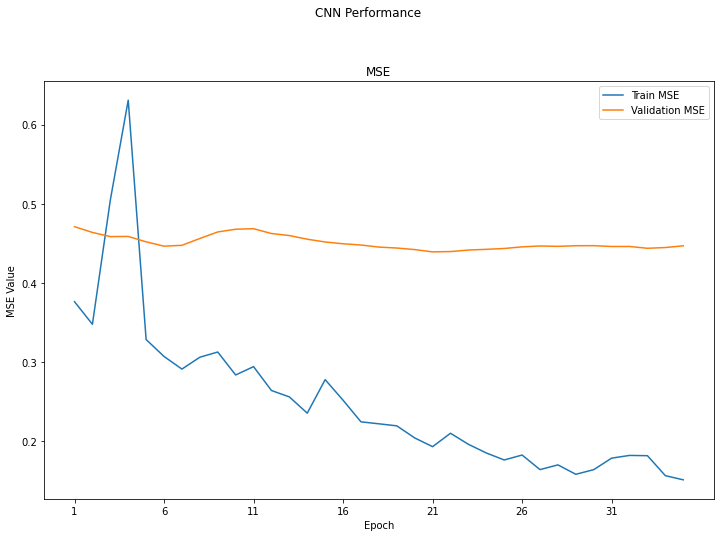

In [148]:
history1 = results_list[0]
plot_loss(history1)



Finally, it's good to test it out on an example. First step is to get the title names of every book in the Dataset. This is done by matching the ASIN with the Metadata, which contains book titles.

In [154]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Grocery_and_Gourmet_Food.json.gz

--2022-04-28 09:50:38--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_Grocery_and_Gourmet_Food.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109586529 (105M) [application/octet-stream]
Saving to: ‘meta_Grocery_and_Gourmet_Food.json.gz’

meta_Grocery_and_Go 100%[===================>] 104.51M  40.1MB/s    in 2.6s    

2022-04-28 09:50:41 (40.1 MB/s) - ‘meta_Grocery_and_Gourmet_Food.json.gz’ saved [109586529/109586529]



In [155]:
!gunzip -k meta_Grocery_and_Gourmet_Food.json.gz

In [156]:
def create_book_title_list(df):
    #Starting from a df with a list of Book-IDS, we can create a dataframe that is a directory of the bookIDS with the Actual Title of the Book.
    #Could be useful to add category and author too...Think about this
    meta_json_path = 'meta_Grocery_and_Gourmet_Food.json'

    size = 100000
    meta = pd.read_json(meta_json_path, lines=True,
                          chunksize=size)
    
    book_ids = pd.DataFrame(df['Book-ID'].unique())
    book_ids = book_ids.rename(columns = {0: 'Book-ID'})
    
    book_list = []
    for chunk_meta in meta:
        book_merged = book_ids.merge(chunk_meta[['asin','title']], how = 'inner' ,left_on ='Book-ID', right_on = 'asin')
        book_list.append(book_merged)
        
    
    book_merged = pd.concat(book_list, ignore_index=True, join='outer', axis=0)
    book_merged2 = book_merged.groupby(by = ['Book-ID','title'], as_index = False).first()

    return book_merged2
    


book_IDS = create_book_title_list(combined)

book_IDS.head(10)

,Book-ID,title,asin
0,B000168QTU,"Celestial Seasonings Tension Tamer Tea, 20 ct",B000168QTU
1,B0001LO3FG,Twinings of London Pure Camomile Herbal Tea Ba...,B0001LO3FG
2,B000F4DKAI,Twinings of London English Afternoon Black Tea...,B000F4DKAI
3,B000H2XXRS,"Nutiva Organic, Cold-Pressed, Unrefined, Virgi...",B000H2XXRS
4,B000HDK0DC,"YumEarth Organic Lollipops, Assorted Flavors, ...",B000HDK0DC
5,B000V1AWBK,"Kitchens Of India Recipe Paste, Vegetable Biry...",B000V1AWBK
6,B000X3TPHS,"YumEarth Organic Lollipops, Assorted Flavors, ...",B000X3TPHS
7,B000YN2GVY,"Bragg Organic Unfiltered Apple Cider Vinegar, ...",B000YN2GVY
8,B00117YT4Y,Designer Whey Premium Natural 100% Whey Protei...,B00117YT4Y
9,B0014WYXYW,"IZZE Sparkling Juice, Blackberry, 8.4 oz Cans,...",B0014WYXYW


Next, we want to get the Top 5 Books (ordered by Sentiment ReviewRating) this user has Read, the Bottom 5 Books, and the Top 5 Recommendations to this user that they have not read. The function below performs this task

In [157]:
def get_top_matches(user_embed_df, book_embed_df, combined_final, book_merged, query_index, model, k_matches = 5):
    #dd
    sampled_user_vector = user_embed_df.iloc[[query_index]]
    sampled_user_ID = sampled_user_vector.index[0]
    
    sampled_user_vector = np.array(user_embed_df.iloc[query_index])
    
    prediction_df = pd.DataFrame(index = book_embed_df.index)
    
    prediction_df.reset_index(inplace = True)
    prediction_df['User-ID'] = sampled_user_ID
    
    def build_prediction_embeddings(x):
        book_row = book_embed_df.loc[book_embed_df.index == x]
        return np.concatenate((sampled_user_vector,np.array(book_row)), axis = None)
    
    
    prediction_df['Full-Vector'] = prediction_df['Book-ID'].apply(build_prediction_embeddings)
    
    X_to_train = np.stack(prediction_df['Full-Vector'])
    
    Y_to_train = model.predict(X_to_train)
    
    prediction_df = prediction_df.merge(book_merged[['Book-ID','title']] , how  = 'outer', on = 'Book-ID')
    prediction_df['Trained_Items'] = Y_to_train
    
    already_read = combined_final[combined_final['User-ID'] == sampled_user_ID]
    
    prediction_df_2 = prediction_df.merge(already_read[['Book-ID','ReviewRating']] , how  = 'left', on = 'Book-ID')
    
    top_5_unrated = prediction_df_2.loc[prediction_df_2['ReviewRating'].isna() == True]
    
    top_5_unrated.sort_values(by = ['Trained_Items'], inplace = True, ascending = False)
    
    top_5_unrated = top_5_unrated.iloc[0:k_matches]
    
    
    rated_books = prediction_df_2.loc[prediction_df_2['ReviewRating'].isna() == False]
    rated_books.sort_values(by = ['ReviewRating'], inplace = True, ascending = False)
    top_5_rated = rated_books.iloc[0:k_matches]

    bottom_5_rated = rated_books.iloc[-k_matches:]
    
    number_of_read_books = rated_books.shape
    return top_5_rated, bottom_5_rated, top_5_unrated, number_of_read_books


In [158]:
query_index = np.random.choice(user_book_matrix.shape[0])

user_id = user_book_matrix.index[query_index]
top_5_rated, bottom_5_rated, top_5_unrated, number_of_read_books = get_top_matches(user_embed_df, book_embed_df, combined, book_IDS, query_index, trained_mods[0], k_matches = 5)


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


The top 5 Books this user reviewed are listed below. They seem to be into fantasy books

In [159]:
top_5_rated

,Book-ID,User-ID,Full-Vector,title,Trained_Items,ReviewRating
0,B000168QTU,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","Celestial Seasonings Tension Tamer Tea, 20 ct",0.059241,0.532609
10,B001D0KG1Y,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","Timothy's World Coffee, Morning Blend, K-Cup P...",0.047759,0.277778


This user did not like Da Vinci Code or Precious, so perhaps they are quite critical of non fantasy books.

In [160]:
bottom_5_rated

,Book-ID,User-ID,Full-Vector,title,Trained_Items,ReviewRating
0,B000168QTU,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","Celestial Seasonings Tension Tamer Tea, 20 ct",0.059241,0.532609
10,B001D0KG1Y,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","Timothy's World Coffee, Morning Blend, K-Cup P...",0.047759,0.277778


The top 5 recommendations are listed below. Our algorithm, based on this User's preferences has recommended the following books, which were reviewed positively by users that had similar tastes as this user. The books are mostly fantasy and mystery. So hopefully, this user enjoys these books!

In [161]:
top_5_unrated

,Book-ID,User-ID,Full-Vector,title,Trained_Items,ReviewRating
11,B00542YXFW,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag",0.044248,NaN
3,B000H2XXRS,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","Nutiva Organic, Cold-Pressed, Unrefined, Virgi...",0.042502,NaN
8,B00117YT4Y,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...",Designer Whey Premium Natural 100% Whey Protei...,0.040737,NaN
15,B00WFDMRDI,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...",ORCHARD VALLEY HARVEST Cranberry Almond Cashew...,0.040383,NaN
4,B000HDK0DC,A1X1CEGHTHMBL1,"[0.031269118976285315, -0.03013522798160398, 0...","YumEarth Organic Lollipops, Assorted Flavors, ...",0.036709,NaN
